In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
from tensorflow.keras.layers import Layer
from sklearn.cluster import KMeans
import tensorflow as tf

class CenterLoss(Layer):
    def __init__(self, num_classes, feature_dim, alpha=0):
        super().__init__()
        self.alpha = alpha
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.centroids = tf.Variable(tf.zeros([num_classes, feature_dim]), dtype=tf.float32, trainable=False)

    def call(self, x, labels):
        centers_batch = tf.gather(self.centroids, tf.argmax(labels, axis=-1))
        diff = x - centers_batch

        intra_class_dist = tf.reduce_sum(tf.square(diff), axis=-1)
        self.add_loss(tf.reduce_mean(intra_class_dist))
        return x

def classification_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 10])
    y_pred = y_pred[:, :10]
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def center_aligned_loss(y_true, y_pred):
    return center_loss_layer(y_pred, y_true)

In [4]:
import keras.utils
from keras.models import load_model

# Custom layer로 딕셔너리 생성
custom_objects = {'CenterLoss': CenterLoss, 'classification_loss' : classification_loss, 'center_aligned_loss' : center_aligned_loss}

# 원하는 모델 불러오기
with keras.utils.custom_object_scope(custom_objects):
    model = load_model('/content/drive/MyDrive/Colab Notebooks/Center_Loss_0.878.h5')

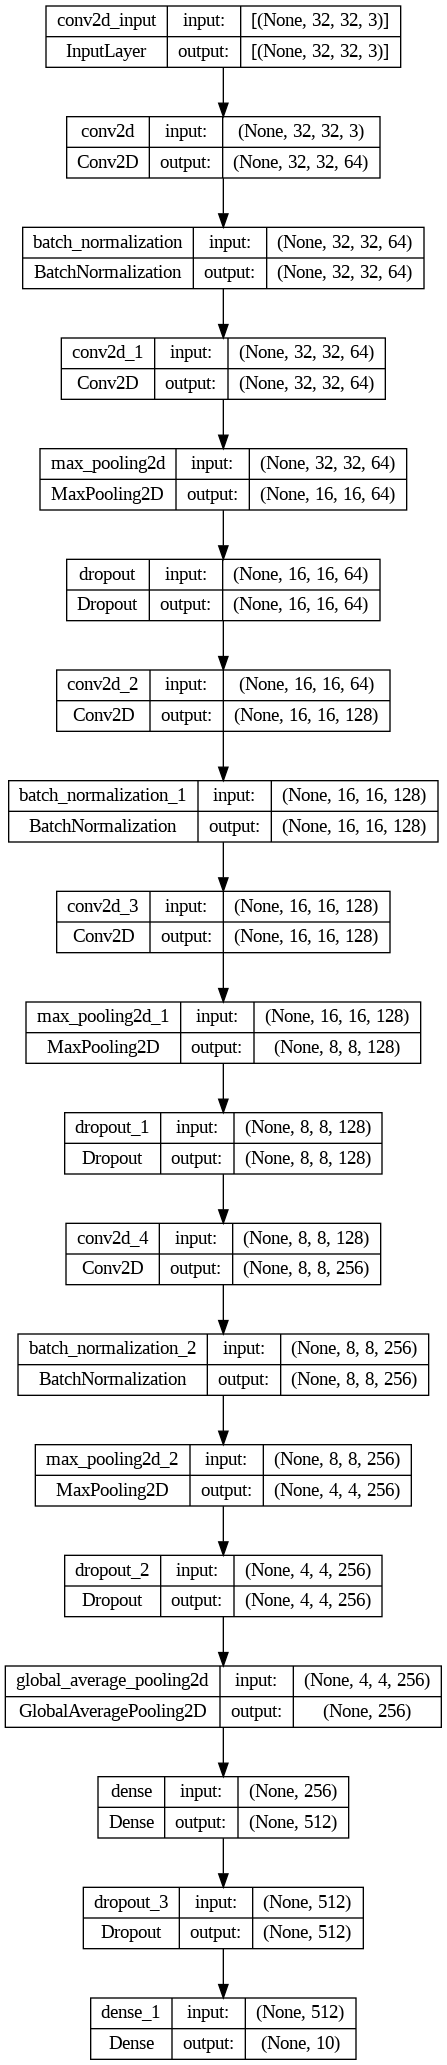

In [5]:
import keras
# sequential_1으로부터 모델 생성
sequential_1 = model.get_layer('sequential_1')
new_model = tf.keras.models.Model(sequential_1.input, sequential_1.output)
keras.utils.plot_model(new_model, show_shapes=True)

<br>
<br>

# T-SNE

아래 코드는 주어진 CNN 모델에서 각 단계별 레이어를 사용하여, 테스트 이미지들의 특징을 2,3차원으로 시각화하기 위해 t-SNE(t-distributed Stochastic Neighbor Embedding) 알고리즘을 적용한 것입니다. 

최종 결과를 확인하기 위해 Seaborn의 scatterplot을 사용하며, 각 데이터 포인트의 클래스 레이블을 색상으로 구분합니다.

각 단계별로 분포가 어떻게 변화하는지 알아보겠습니다.

1. First conv2d layer
2. Last conv2d layer
3. First dense layer
4. Last class layer




## 1. First conv2d layer

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=new_model.input, outputs=new_model.get_layer('conv2d').output)
intermediate_output = intermediate_model.predict(test_images)

# 차원 축소를 위한 데이터 형태 변경
num_samples, x_shape, y_shape, num_channels = intermediate_output.shape
reshaped_output = np.reshape(intermediate_output, (num_samples, x_shape * y_shape * num_channels))
print(reshaped_output.shape)

313/313 [==============================] - 7s 2ms/step
(10000, 65536)


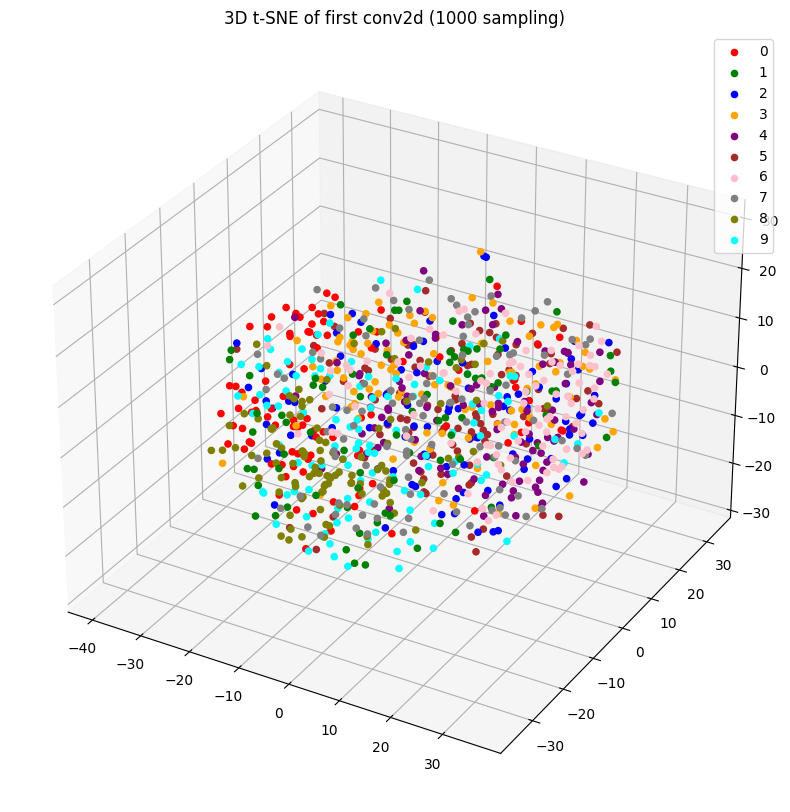

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3) # 3차원으로 축소
pca = PCA(n_components=50)  # 주성분 분석을 이용해 50 차원으로 줄입니다.
pca_output = pca.fit_transform(reshaped_output)
tsne_output_3d = tsne_3d.fit_transform(pca_output)

sample_size = 1000  # 10000개는 너무 많으므로 샘플링
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = pca_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output_3d = tsne_3d.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# 레이블별로 데이터를 분할하고 색상을 지정하여 산점도에 추가
for label in range(10):
    indices = np.argwhere(np.argmax(sampled_labels, axis=1) == label).flatten()
    ax.scatter(tsne_output_3d[indices, 0], tsne_output_3d[indices, 1], tsne_output_3d[indices, 2], c=colors[label], label=label)

ax.set_title('3D t-SNE of first conv2d (1000 sampling)')
ax.legend()
plt.show()

## 2 : Last conv2d layer (conv2d_4)

In [8]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=new_model.input, outputs=new_model.get_layer('conv2d_4').output)
intermediate_output = intermediate_model.predict(test_images)

# 차원 축소를 위한 데이터 형태 변경
num_samples, x_shape, y_shape, num_channels = intermediate_output.shape
reshaped_output = np.reshape(intermediate_output, (num_samples, x_shape * y_shape * num_channels))
print(reshaped_output.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 16384)


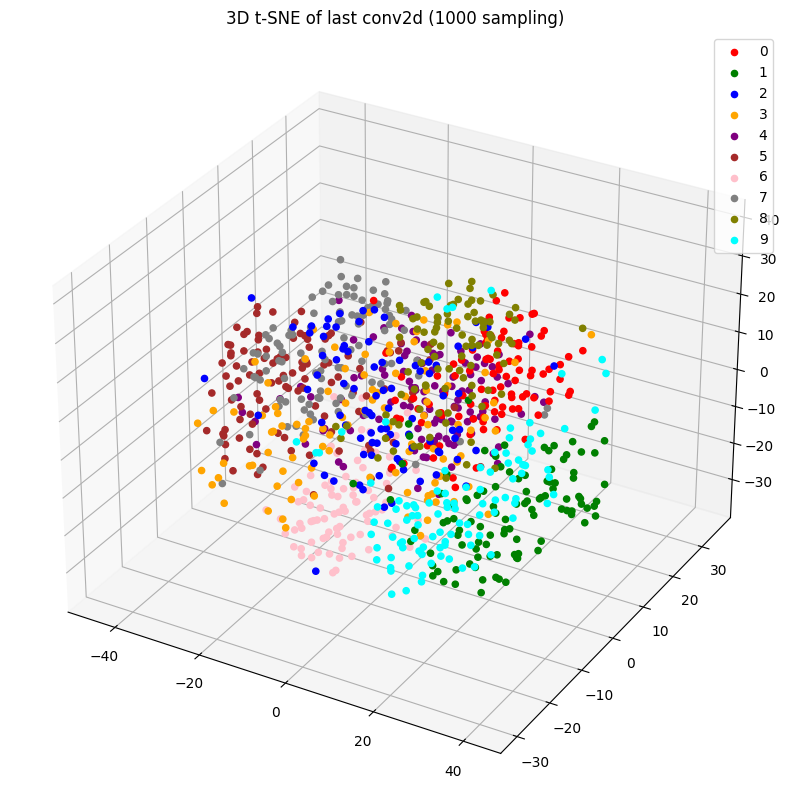

In [9]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3) # 3차원으로 축소
pca = PCA(n_components=50)  # 주성분 분석을 이용해 50 차원으로 줄입니다.
pca_output = pca.fit_transform(reshaped_output)
tsne_output_3d = tsne_3d.fit_transform(pca_output)

sample_size = 1000  # 10000개는 너무 많으므로 샘플링
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = pca_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output_3d = tsne_3d.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# 레이블별로 데이터를 분할하고 색상을 지정하여 산점도에 추가
for label in range(10):
    indices = np.argwhere(np.argmax(sampled_labels, axis=1) == label).flatten()
    ax.scatter(tsne_output_3d[indices, 0], tsne_output_3d[indices, 1], tsne_output_3d[indices, 2], c=colors[label], label=label)

ax.set_title('3D t-SNE of last conv2d (1000 sampling)')
ax.legend()
plt.show()

## 3. First dense layer

In [10]:

from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=new_model.input, outputs=new_model.get_layer("dense").output)
intermediate_output = intermediate_model.predict(test_images)
num_samples = intermediate_output.shape[0]

# 차원 축소를 위한 데이터 형태 변경 (이 경우 변경할 필요가 없습니다.)
reshaped_output = intermediate_output

print(reshaped_output.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 512)


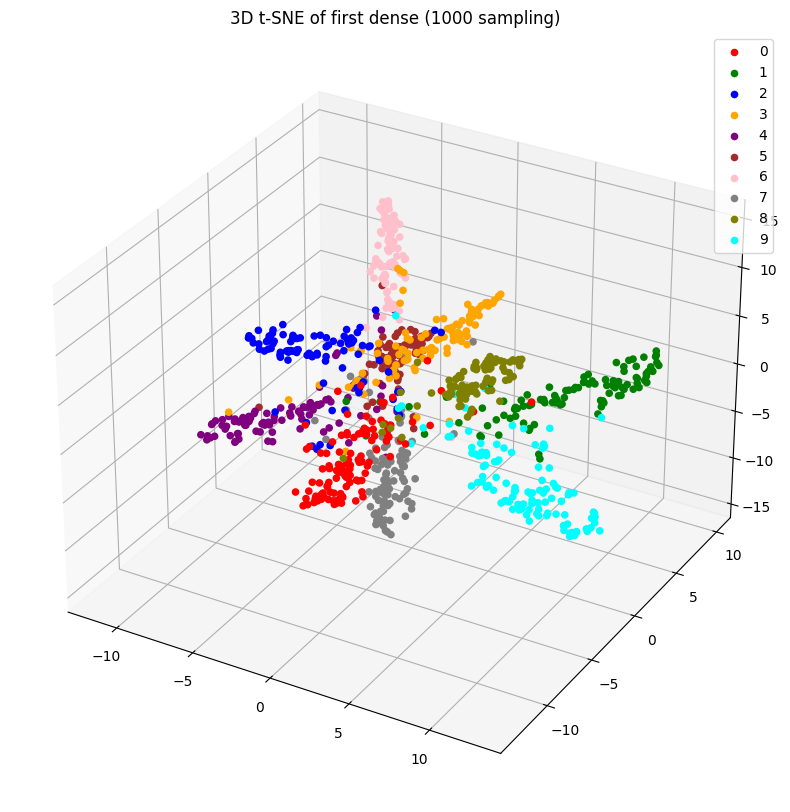

In [11]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3) # 3차원으로 축소
pca = PCA(n_components=50)  # 주성분 분석을 이용해 50 차원으로 줄입니다.
pca_output = pca.fit_transform(reshaped_output)
tsne_output_3d = tsne_3d.fit_transform(pca_output)

sample_size = 1000  # 10000개는 너무 많으므로 샘플링
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = pca_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output_3d = tsne_3d.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 레이블별로 데이터를 분할하고 색상을 지정하여 산점도에 추가
for label in range(10):
    indices = np.argwhere(np.argmax(sampled_labels, axis=1) == label).flatten()
    ax.scatter(tsne_output_3d[indices, 0], tsne_output_3d[indices, 1], tsne_output_3d[indices, 2], c=colors[label],  label=class_names[label])

ax.set_title('3D t-SNE of first dense (1000 sampling)')
ax.legend()
plt.show()

<br>
<br>

## 2. last dense layer

이번에는 주어진 CNN 모델에서 **맨 마지막 dense 층**을 사용하여, 테스트 이미지들의 특징을 2,3차원으로 시각화하기 위해 t-SNE(t-distributed Stochastic Neighbor Embedding) 알고리즘을 적용한 것입니다.

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Input data 준비하기
input_images = test_images

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=model.get_layer("input_1").input, outputs=model.get_layer("class").output)
intermediate_output = intermediate_model.predict(input_images)

num_samples = intermediate_output.shape[0]

# 차원 축소를 위한 데이터 형태 변경
reshaped_output = intermediate_output
print(reshaped_output.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 10)


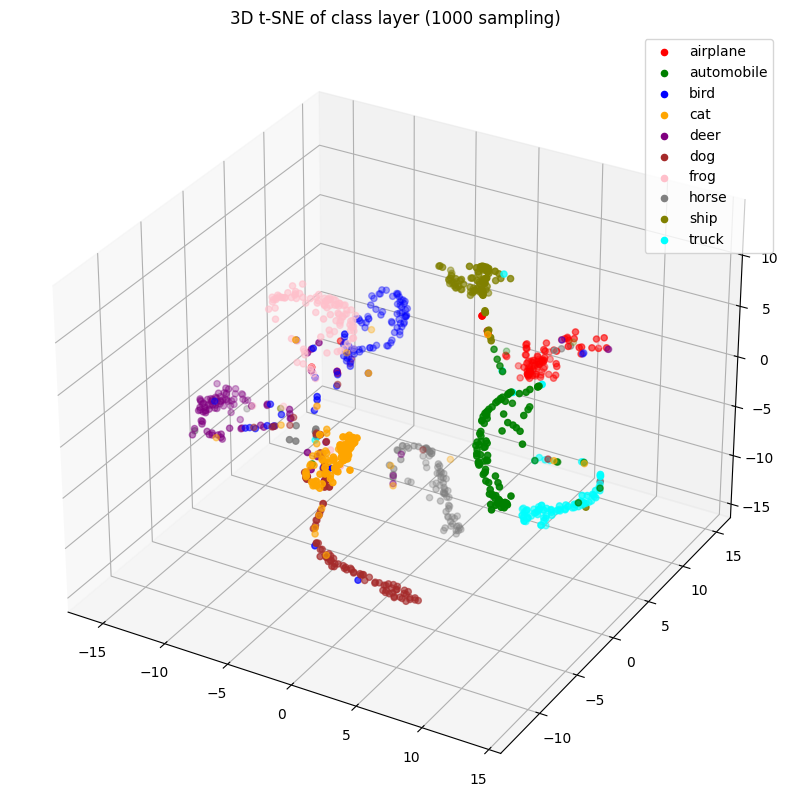

In [18]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=3)

sample_size = 1000  # 샘플 크기
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

palette = sns.color_palette("deep", 10)

for i, target in enumerate(np.unique(np.argmax(sampled_labels, axis=1))):
    indices = np.where(np.argmax(sampled_labels, axis=1) == target)
    ax.scatter(
        tsne_output[indices, 0],
        tsne_output[indices, 1],
        tsne_output[indices, 2],
        color=colors[i],
        label=class_names[i]
    )

plt.title("3D t-SNE of class layer (1000 sampling)")
ax.legend()
plt.show()